# SPR 2022, Pre-conference Workshop
# Methods for Analyzing Neural Oscillations and Aperiodic Activity

The first part of the workshop (Digital Signal Processing and Simulations) will consists of 2 parts separated in 2 notebooks. In the first notebook, you learned about how power spectra change depending on the simulated time signal. The second notebook (this one) will explore the basics of filtering, and how filtering can alter your data, so you can be mindful of it during your own analyses. Below are the topics considered in this notebook:

- xxxx
    - yyyy
    - bla
- yes
    - no
    - maybe

## Lesson 2: Digital Signal Processing - Filtering simulated and real data

In this notebook, we will go over some functions to simulate your own data using the NeuroDSP library
(https://neurodsp-tools.github.io/neurodsp/index.html)

### Set-up

#### Install necessary packages (for Colab) 

In [2]:
!pip install neurodsp

#### Imports

In [3]:
# general 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Voytek Lab tools
from neurodsp import spectral
from neurodsp import filt
from neurodsp import sim
from neurodsp import utils

#### Settings

In [4]:
# signal params
N_SECONDS = 100 # signal duration
FS = 1000 # sampling frequency

In [5]:
# plotting params

# fontsize
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10

# color
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['axes.facecolor'] = 'w'

#### Functions

In [6]:
def plot_signal_and_power(time, signal, freq, spectrum, title='', logscale=False, xlims=None):
    '''
    Plot time-series and corresponding power spectum

    Parameters
    ----------
    time : 1D array, float
        time-vector for signal
    signal : 1D array, float
        time-series e.g. LFP or EEG
    freq : 1D array, float
        frequency-vector for spectrum
    spectrum : 1D array, float
        power spectrum of signal
    title : str, optional
        figure title. The default is ''.
    logscale : bool, optional
        whether to plot the spectrum in log-log space. The default is False.
    xlims : 1D array (len=2), optional
        x-axis limits for time-series plot ([lower_limit, upper_limit]). 
        The default is None.

    '''
    # create figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12,4], gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
    fig.suptitle(title)

    # plot signal
    ax1.set(xlabel='time (s)', ylabel='voltage (au)', title='Time-series')
    ax1.plot(time, signal)
    if xlims:
        ax1.set_xlim(xlims)
        
    # plot spectra
    ax2.set(xlabel='frequency (Hz)', ylabel='power (au)', title='Power Spectral Density')
    ax2.plot(freq, spectrum);
    ax2.set_xlim([.1,200])
    if logscale:
        ax2.set(xscale='log', yscale='log')

    

### Filtering basics -- CHECK WHETHER WE'RE ACTUALLY DOING BURTHERWORTH OR NOT
First of all, what is filtering? A single signal can contain many oscillations. The goal of filtering your data is to remove unwanted frequencies (such as line-noise), or isolate the frequency band of interest for further analysis.

Let's start with an example that contains 2 oscillations (from the previous notebook):

In [7]:
# settings
freq_oscillations = [5, 60] # oscillation peak frequency
osc_amp = [1, 0.5] # oscillation amplitude

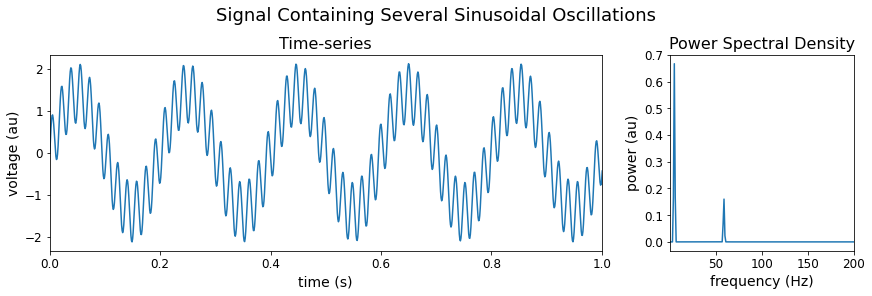

In [8]:
# simulate signal
time = utils.create_times(N_SECONDS, FS)
signal_sins = np.zeros_like(time)

for i_osc in range(len(freq_oscillations)):
    signal_sins += sim.sim_oscillation(N_SECONDS, FS, freq_oscillations[i_osc]) * osc_amp[i_osc]

# compute power spectrum
freq, psd_sins = spectral.compute_spectrum(signal_sins, FS)

# plot
plot_signal_and_power(time, signal_sins, freq, psd_sins, 
    title='Signal Containing Several Sinusoidal Oscillations', xlims=[0,1])




This signal is composed of two sin waves oscillating at different frequencies, a high-amplitude, slow frequency wave and a low-amplitude, high frequency wave. We can use a filter to get just one component of this complex wave and ignore everything else. The filter we will use is known as a Butterworth filter, you can read more about it [here](https://en.wikipedia.org/wiki/Butterworth_filter). In short, this filter type is known as a band-pass filter, keeping only frequencies within a specified range.

We will be using a NeuroDSP function [(filter_signal)](https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.filt.filter_signal.html) that uses the Butterworth filter. 

There are many types of filters and none of them are perfect. Each filter has advantages and disadvantages and the details of these are important, but won't be covered in full details here. 

A Butterworth filter takes in X parameters:

    The sampling rate of the data
    A lower bound on the frequency band you want to keep
    An upper bound on the frequency band you want to keep
    An order of the filter. This determines how sharply the filter cuts off bounding frequencies.

Below are some functions to allow us to use the Butterworth filter. We will ignore the details of these functions for now as the most important part is not how to create a filter, but to understand why we use them.


In [9]:
# Filter oscillations in signal
low_freq = filt.filter_signal(signal_sins, fs=FS, pass_type='bandpass', f_range=(2, 7))
high_freq = filt.filter_signal(signal_sins, fs=FS, pass_type='bandpass', f_range=(50, 70))

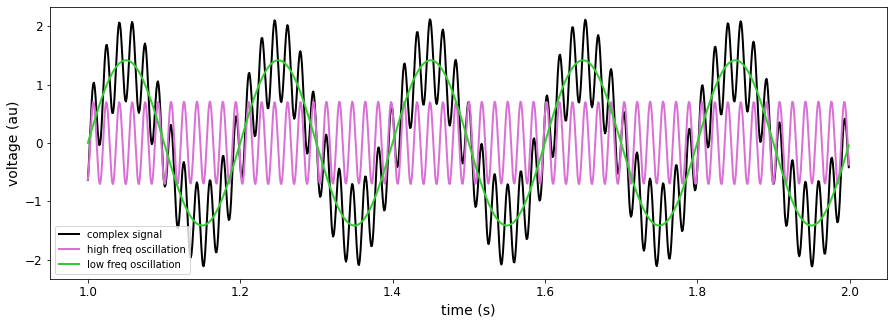

In [10]:
# Plot the signals and filtered signals in same plot
plt.figure(figsize=(15,5))
plt.plot(time[1000:2000], signal_sins[1000:2000], color='black', lw=2, label='complex signal')
plt.plot(time[1000:2000], high_freq[1000:2000], color='orchid', lw=2, label='high freq oscillation')
plt.plot(time[1000:2000], low_freq[1000:2000], color='limegreen', lw=2, label='low freq oscillation')

plt.xlabel('time (s)')
plt.ylabel('voltage (au)')

plt.legend()
plt.show()

### Filtering non-sinusoidal signals

Let's use the same frequencies as before, but this time, we're creating non-sinusoidal oscillations, by adding an argument "cycle" and "width". With a sawtooth shape, a width of 0.5 gives a triangle shape. Lower, gives a sharper rise, higher gives a sharper decay.

You can see how the power spectrum changes when you alter those numbers

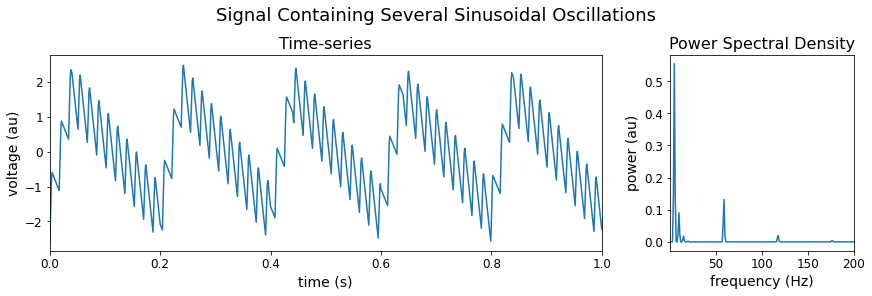

In [11]:
# simulate signal
time = utils.create_times(N_SECONDS, FS)
signal_saw = np.zeros_like(time)

CYCLE = 'sawtooth'
WIDTH = 0.2


for i_osc in range(len(freq_oscillations)):
    signal_saw += sim.sim_oscillation(N_SECONDS, FS, freq_oscillations[i_osc], 
                                       cycle=CYCLE, width=WIDTH) * osc_amp[i_osc]

# compute power spectrum
freq, psd_sins = spectral.compute_spectrum(signal_saw, FS)

# plot
plot_signal_and_power(time, signal_saw, freq, psd_sins, 
    title='Signal Containing Several Sinusoidal Oscillations', xlims=[0,1])


In [16]:
# Filter oscillations in signal
low_freq = filt.filter_signal(signal_saw, fs=FS, pass_type='bandpass', f_range=(2, 7))
high_freq = filt.filter_signal(signal_saw, fs=FS, pass_type='bandpass', f_range=(50, 70))

/Users/quirine/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/quirine/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


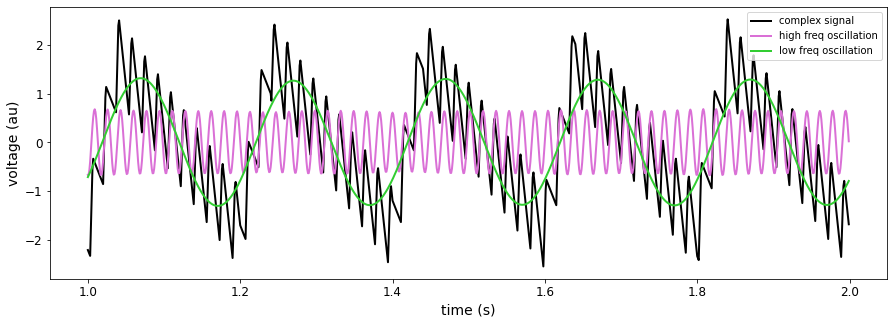

In [17]:
# Plot the signals and filtered signals in same plot
plt.figure(figsize=(15,5))
plt.plot(time[1000:2000], signal_saw[1000:2000], color='black', lw=2, label='complex signal')
plt.plot(time[1000:2000], high_freq[1000:2000], color='orchid', lw=2, label='high freq oscillation')
plt.plot(time[1000:2000], low_freq[1000:2000], color='limegreen', lw=2, label='low freq oscillation')

plt.xlabel('time (s)')
plt.ylabel('voltage (au)')

plt.legend()
plt.show()